In [1]:
import configparser
import oandapy as opy
import warnings
from datetime import datetime, timedelta

In [2]:

warnings.filterwarnings('ignore')
config = configparser.ConfigParser()
config.read('oanda.cfg')
oanda = opy.API(environment='practice', access_token = config['oanda']['access_token'])


In [3]:

import pandas as pd

data = oanda.get_history(instrument = 'EUR_USD', # our instrument
                        start = '2016-12-08', # start date of data
                        end = '2016-12-10', # end date of data
                        granularity = 'M1') # 1 minute bars
                         
df = pd.DataFrame(data['candles']).set_index('time')
df.index = pd.DatetimeIndex(df.index)
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2658 entries, 2016-12-08 00:00:00 to 2016-12-09 21:59:00
Data columns (total 10 columns):
closeAsk    2658 non-null float64
closeBid    2658 non-null float64
complete    2658 non-null bool
highAsk     2658 non-null float64
highBid     2658 non-null float64
lowAsk      2658 non-null float64
lowBid      2658 non-null float64
openAsk     2658 non-null float64
openBid     2658 non-null float64
volume      2658 non-null int64
dtypes: bool(1), float64(8), int64(1)
memory usage: 210.3 KB


In [4]:

import numpy as np

df['returns'] = np.log(df['closeAsk'] / df['closeAsk'].shift(1))
cols = []

for momentum in [15, 30, 60, 120]:
    col = 'position_%s' % momentum
    df[col] = np.sign(df['returns'].rolling(momentum).mean())
    cols.append(col)
    

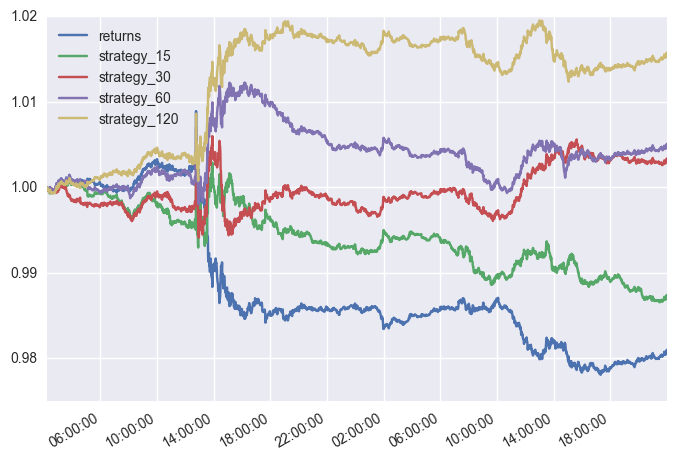

In [5]:

%matplotlib inline
import seaborn as sns; sns.set

strats = ['returns']

for col in cols:
    strat = 'strategy_%s' % col.split('_')[1]
    df[strat] = df[col].shift(1) * df['returns']
    strats.append(strat)
    
df[strats].dropna().cumsum().apply(np.exp).plot()
    

In [6]:

class MomentumTrader(opy.Streamer):
    def __init__(self, momentum, *args, **kwargs):
        opy.Streamer.__init__(self, *args, **kwargs)
        self.ticks = 0
        self.position = 0
        self.df = pd.DataFrame
        self.momentum = momentum
        self.units = 100000
    
    def create_order(self, side, units):
        order = oanda.create_order(config['oanda']['account_id'], 
                instrument = 'EUR_USD', units = units, side = side, type = 'market')
        print('\n', order)
        
    def on_success(self, data):
        self.ticks += 1
        # print(self.ticks, end = ', ')
        # append the new tick data to the Dataframe object
        self.df = self.df.append(pd.DataFrame(data['tick'], index = [data['tick']['time']]))
        # transform the time information to a DatetimeIndex object
        self.df.index = pd.DatetimeIndex(self.df['time'])
        # resample the data set to a new, homogeneous interval
        dfr = self.df.resample('5s').last()
        # calculate log returns
        dfr['returns'] = np.log(dfr['ask'] / dfr['ask'].shift(1))
        # derive the positioning according to the momentum strategy
        dfr['position'] = np.sign(dfr['returns'].rolling(self.momentum).mean())
        if dfr['position'].ix[-1] == 1:
            # take long position
            if self.position == 0:
                self.create_order('buy', self.units)
            elif self.position == -1:
                self.create_order('buy', self.units * 2)
            self.position = 1
        elif dfr['position'].ix[-1] == -1:
            # take short posiiton
            if self.position == 0:
                self.create_order('sell', self.units)
            elif self.position == 1:
                self.create_order('sell', self.units * 2)
            self.position = -1
        if self.ticks == 250:
            # close out the position
            if self.position == 1:
                self.create_order('sell', self.units)
            elif self.position == -1:
                self.create_order('buy', self.units)
            self.disconnect()
    
    def on_error(self, data):
        self.disconnect()
                                 

In [7]:

mt = MomentumTrader(momentum=12, environment='practice',
                    access_token=config['oanda']['access_token'])
mt.rates(account_id=config['oanda']['account_id'],
         instruments=['DE30_EUR'], ignore_heartbeat=True)


In [ ]:
# ALternatively, avoid momentum trading altogether and just place an order
trade_expire = datetime.utcnow() + timedelta(days = 1)
trade_expire = trade_expire.isoformat("T") + "Z"
response = oanda.create_order(account_id=config['oanda']['account_id'],
                             instrument = 'EUR_USD',
                             units = 1000,
                             side='sell',
                             type='limit',
                                price = 1.0556,
                             expiry = trade_expire)